# Import Ntuple

In [1]:
%load_ext autoreload
%autoreload 2

import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util

training_variables = util.training_variables
columns = util.all_relevant_variables + ['Ecms','B0_CMS_roeP_my_mask']

Welcome to JupyROOT 6.26/14


In [2]:
# e channel

cut = '(5<B0_roeMbc_my_mask) & (-4<B0_roeDeltae_my_mask) & (B0_roeDeltae_my_mask<1) & (B0_dr<0.1)'

# Load data files
MC_4S = uproot.concatenate([f'../../Samples/MC15ri/e_channel/local_200fb_control/*.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

MC_4Soffres = uproot.concatenate([f'../../Samples/MC15ri/e_channel/4Soffres_quaxo_6.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

data_4Soffres = uproot.concatenate([f'../../Samples/Data/e_channel/*4Soffres_quaxo_1.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

df_mc_4S = pd.DataFrame(MC_4S)
df_mc_4Soffres = pd.DataFrame(MC_4Soffres)
df_data_4Soffres = pd.DataFrame(data_4Soffres)

In [18]:
# mu channel

cut = '(5<B0_roeMbc_my_mask) & (-4<B0_roeDeltae_my_mask) & (B0_roeDeltae_my_mask<1) & (B0_dr<0.1)'

# Load data files
MC_4S = uproot.concatenate([f'../../Samples/MC15ri/mu_channel/local_200fb_test/*.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

MC_4Soffres = uproot.concatenate([f'../../Samples/MC15ri/mu_channel/4Soffres_quaxo_1.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

data_4Soffres = uproot.concatenate([f'../../Samples/Data/mu_channel/*4Soffres_quaxo_1.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

df_mc_4S = pd.DataFrame(MC_4S)
df_mc_4Soffres = pd.DataFrame(MC_4Soffres)
df_data_4Soffres = pd.DataFrame(data_4Soffres)

In [3]:
lgb_tight = 'sig_prob==largest_prob and sig_prob>0.65 and fakeD_prob<0.05'
lgb_trueD = 'fakeD_prob<0.1'

In [4]:
for df in [df_mc_4S, df_mc_4Soffres,df_data_4Soffres,]: #df_mc_4S,df_data_4S]:
    # df.eval(f'cos_D_l = (D_px*ell_px + D_py*ell_py + D_pz*ell_pz)/(D_p*ell_p)', inplace=True)
    df.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
    df.eval('p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

In [5]:
df_mc_4Soffres.eval('roeMbc_cor = ( (10.58/2)**2 - (B0_CMS_roeP_my_mask*10.58/Ecms)**2 )**0.5', inplace=True)
df_mc_4Soffres['B0_roeMbc_my_mask'] = df_mc_4Soffres['roeMbc_cor']
df_mc_4S.eval('roeMbc_cor = B0_roeMbc_my_mask', inplace=True)

In [ ]:
# # ag + BCS
# df_mc_4S_ag = util.apply_mva_bcs(df_mc_4S, training_variables, ag_tight, 
#                                   library='ag',version='ag-20241203_203215',model='NeuralNetTorch')
# df_mc_4Soffres_ag = util.apply_mva_bcs(df_mc_4Soffres, training_variables, ag_tight, 
#                                   library='ag',version='ag-20241203_203215',model='NeuralNetTorch')
# df_data_4Soffres_ag = util.apply_mva_bcs(df_data_4Soffres, training_variables, ag_tight, 
#                                   library='ag',version='ag-20241203_203215',model='NeuralNetTorch')

In [6]:
# lgb + BCS
df_mc_4S_lgb = util.apply_mva_bcs(df_mc_4S, training_variables, lgb_trueD,library='lgbm')
df_mc_4Soffres_lgb = util.apply_mva_bcs(df_mc_4Soffres, training_variables, lgb_trueD,library='lgbm')
df_data_4Soffres_lgb = util.apply_mva_bcs(df_data_4Soffres, training_variables, lgb_trueD,library='lgbm')

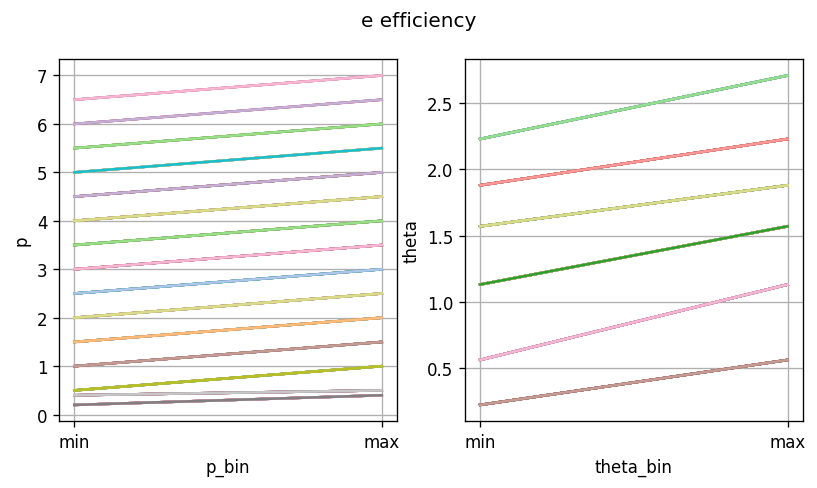

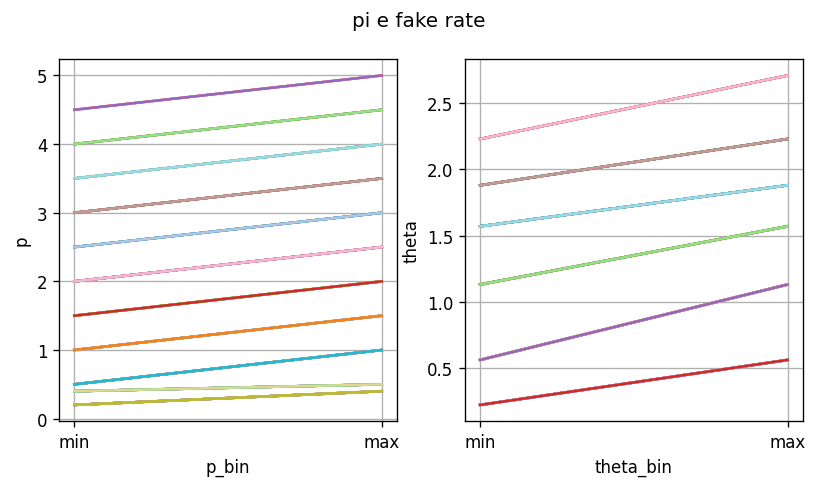

In [5]:
# PID corrections, get tables
pid = util.PID_corrections()
exclude_e_bins_query = "not (p_min == 0.2 and p_max == 5.0) \
and not (theta_min == 0.22 and theta_max == 2.71) \
and not (theta_min == 0.56 and theta_max == 2.23)"
e_eff, e_fake = pid.get_lepton_tables(lepton='e', var="pidChargedBDTScore_e",
                          thres=0.9, exclude_bins=exclude_e_bins_query)
K_eff, K_fake = pid.get_hadron_tables(new_table=False, hadron='K', var='kaonIDNN', thres=0.9)

Required variables: ['ell_p', 'ell_charge', 'ell_theta', 'ell_PDG', 'ell_mcPDG']
Coverage:
PID ell: 93.8%
Required variables: ['D_K_p', 'D_K_charge', 'D_K_cosTheta', 'D_K_PDG', 'D_K_mcPDG']
Coverage:
PID D_K: 92.1%


/tmp/ipykernel_2125318/671596483.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PIDWeight'] = df[['ell_Weight', 'D_K_Weight']].product(axis=1)


Required variables: ['ell_p', 'ell_charge', 'ell_theta', 'ell_PDG', 'ell_mcPDG']
Coverage:
PID ell: 89.1%
Required variables: ['D_K_p', 'D_K_charge', 'D_K_cosTheta', 'D_K_PDG', 'D_K_mcPDG']
Coverage:
PID D_K: 88.3%


/tmp/ipykernel_2125318/671596483.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['PIDWeight'] = df[['ell_Weight', 'D_K_Weight']].product(axis=1)


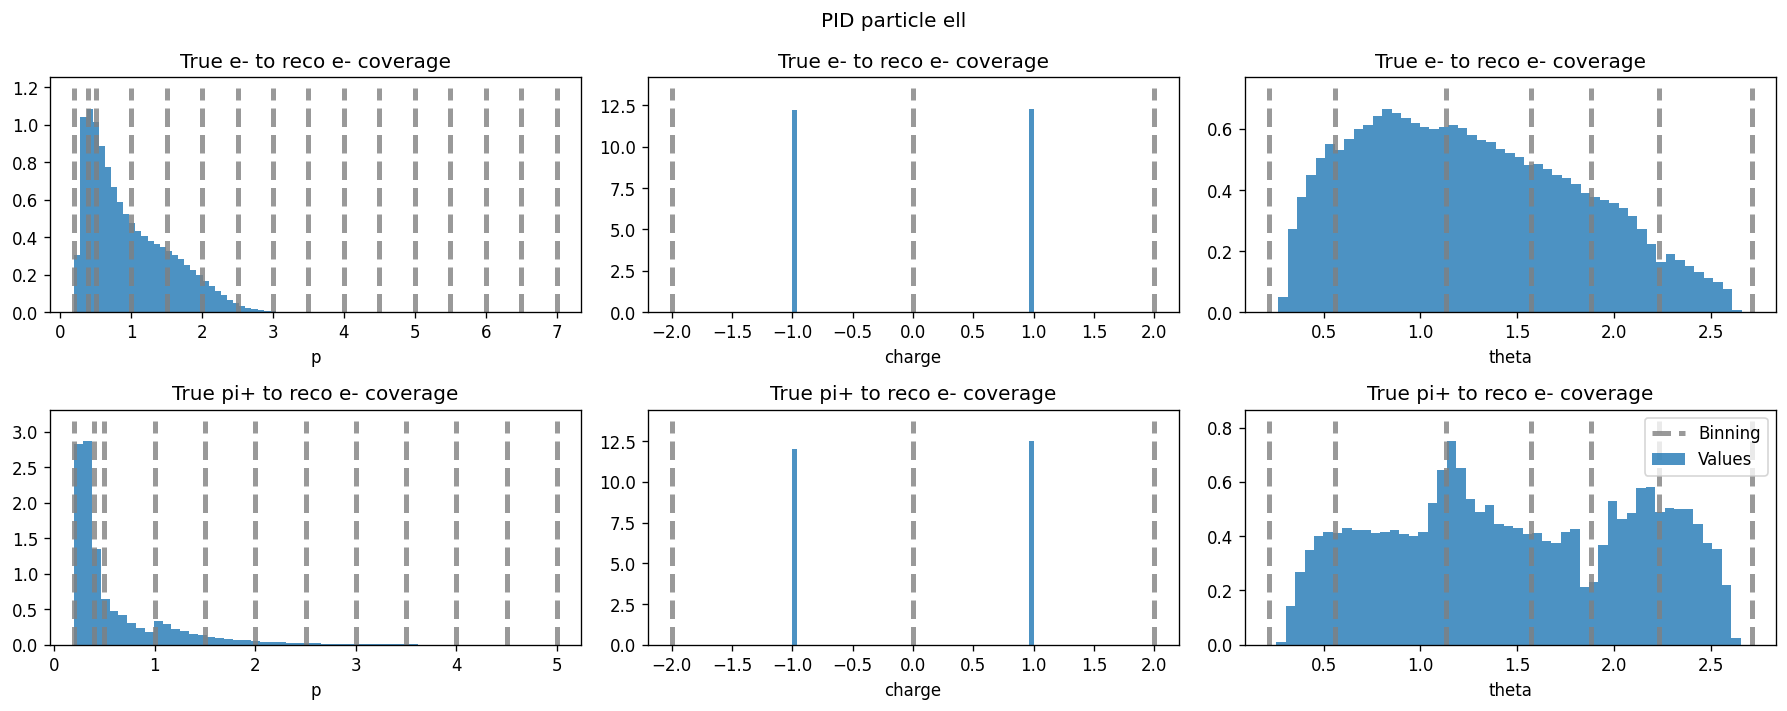

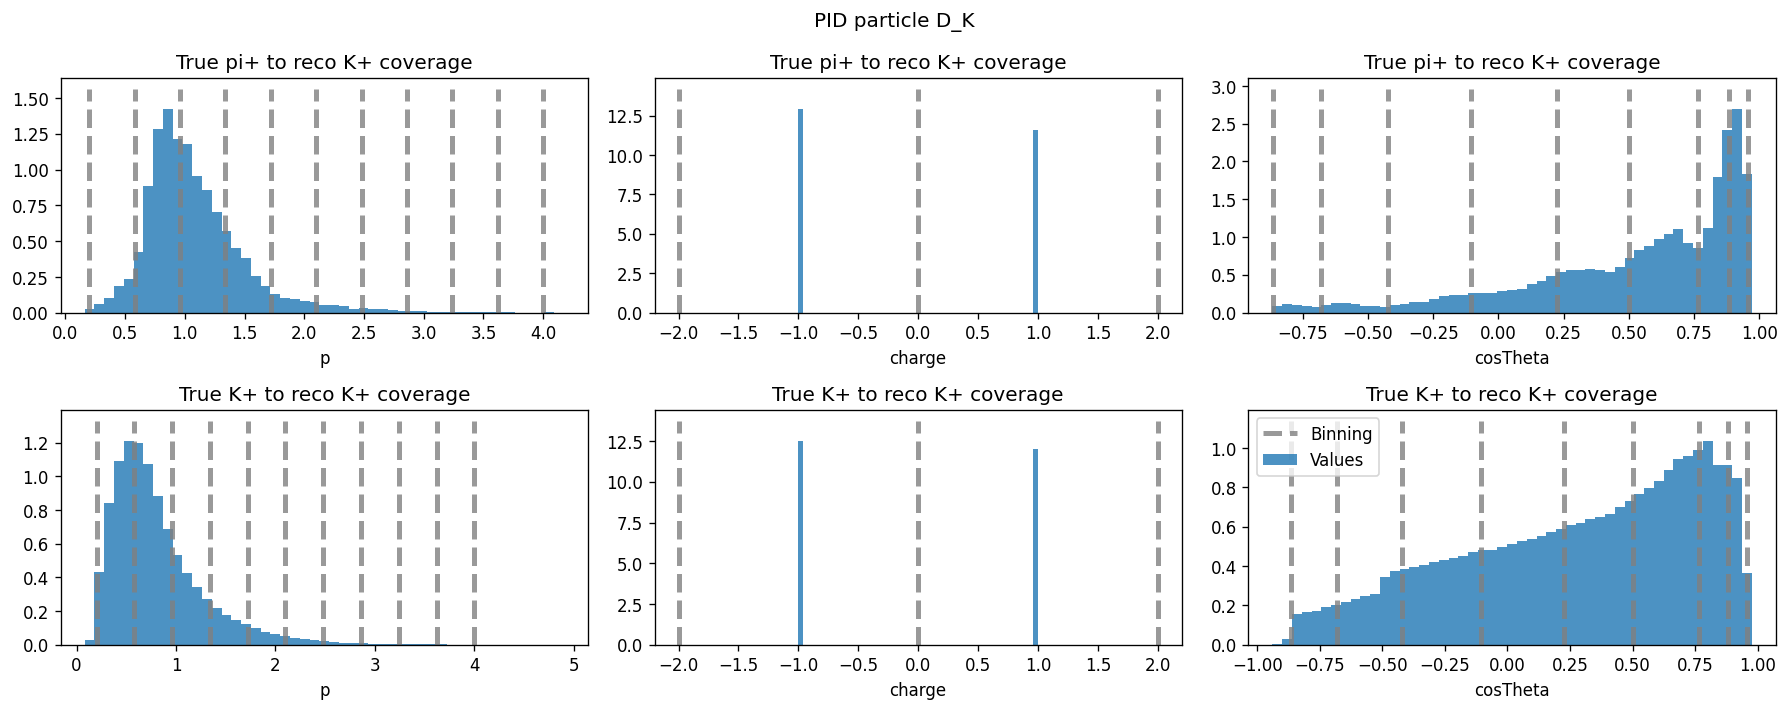

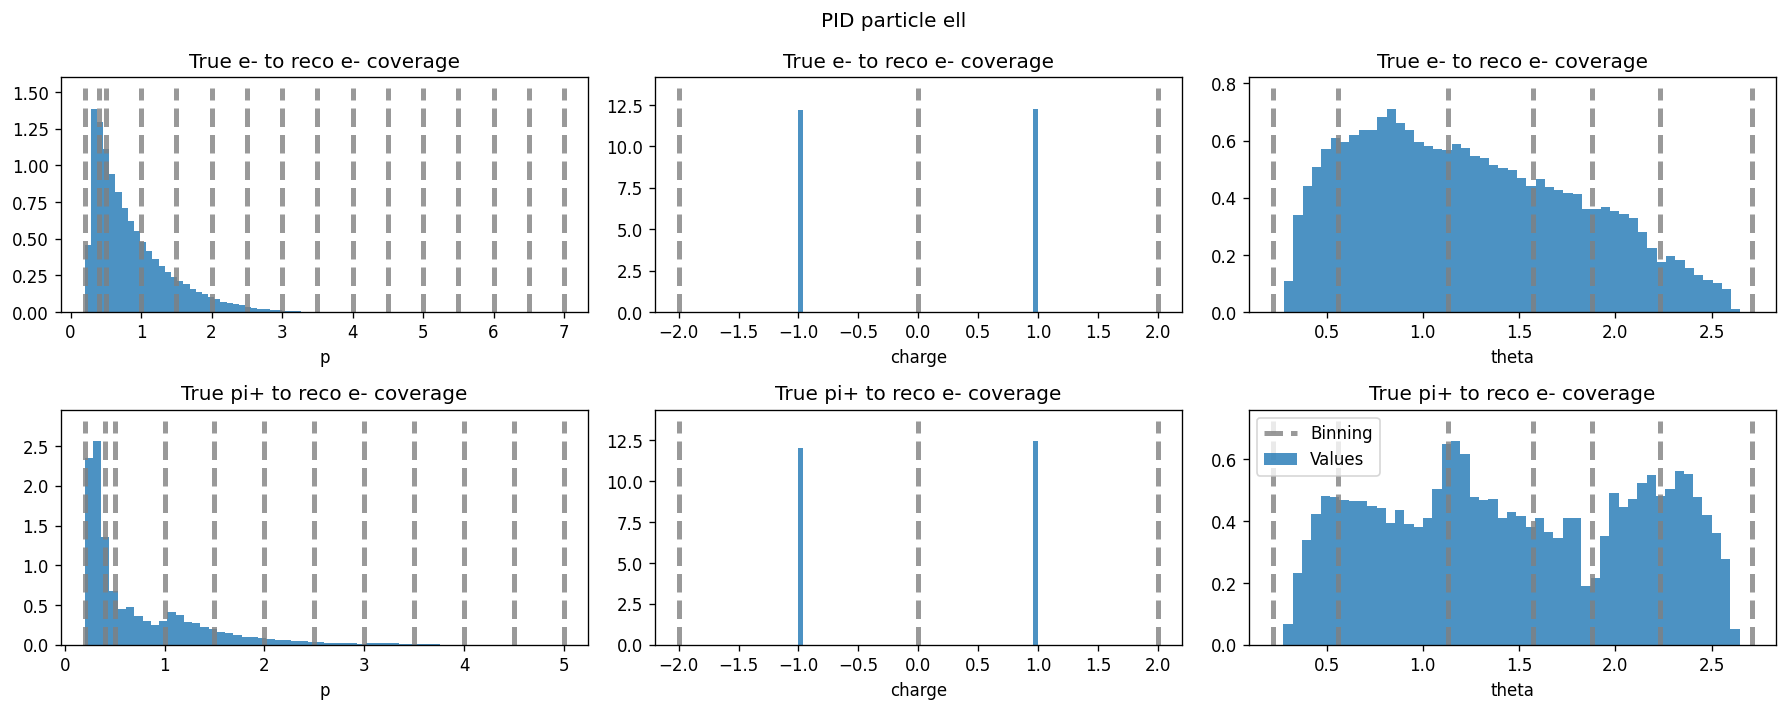

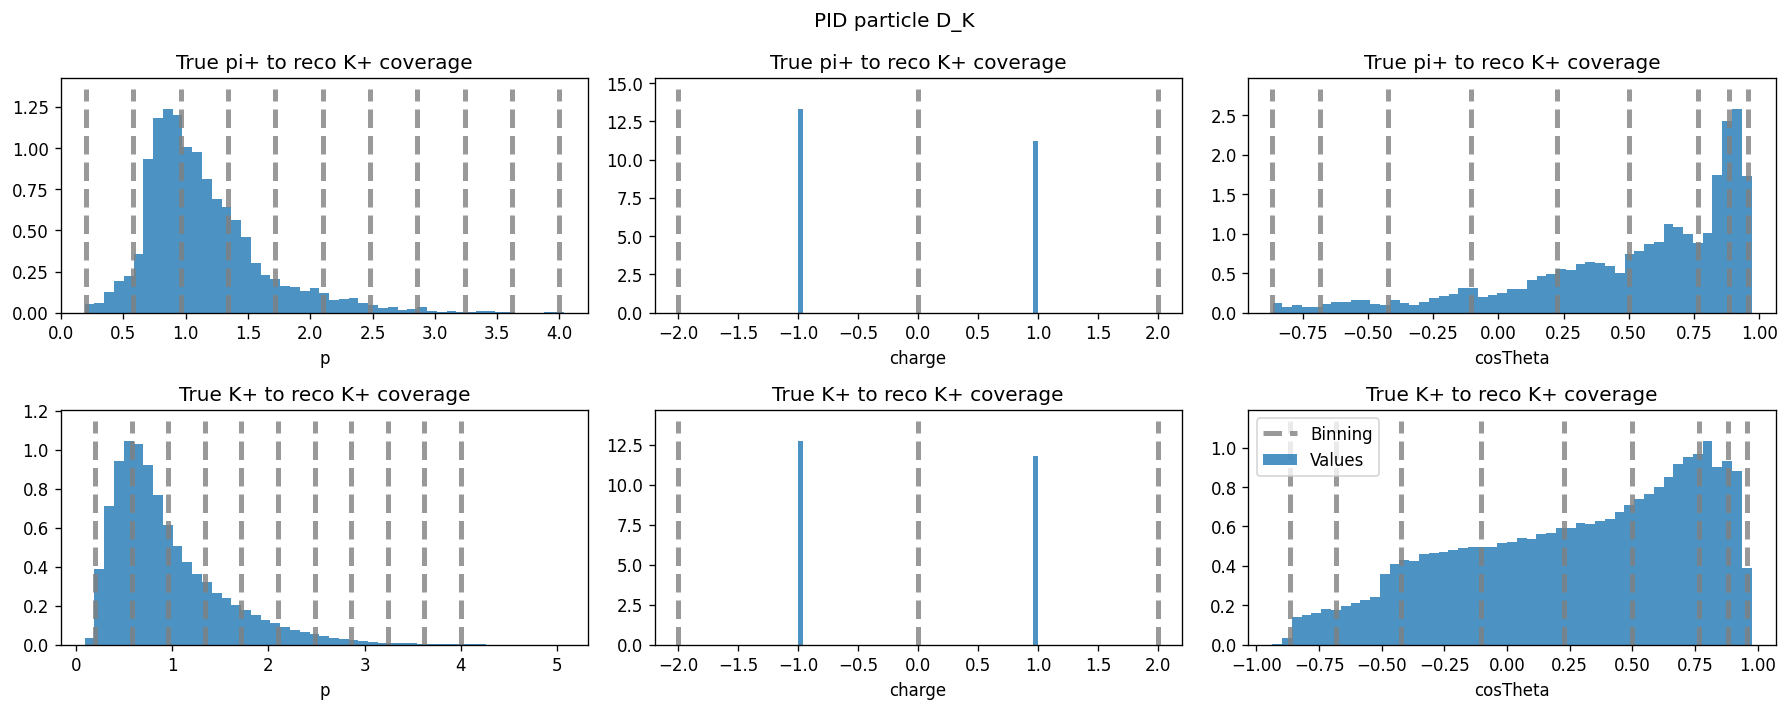

In [9]:
# Apply PID corrections
for df in [df_mc_4S_lgb, df_mc_4Soffres_lgb]:
    pid.apply_corrections(eff_table=e_eff, fake_table=e_fake, df=df, plots=True,
                          p='e', var='pidChargedBDTScore_e', thres=0.9)
    pid.apply_corrections(eff_table=K_eff, fake_table=K_fake, df=df, plots=True,
                          p='K', var='kaonIDNN', thres=0.9)
    df['PIDWeight'] = df[['ell_Weight', 'D_K_Weight']].product(axis=1)
    df = df.copy()

In [7]:
samples_4Soff=util.classify_mc_dict(df_mc_4Soffres_lgb, 'e', template=False)
samples_sig = util.classify_mc_dict(df_mc_4S_lgb, 'e', template=False)
mpl=util.mpl(samples_4Soff,df_data_4Soffres_lgb)
# df_conti_conti = samples['bkg_continuum']
for name, df in samples_4Soff.items():
    print(name, len(df))

bkg_fakeD 43801
bkg_TDFl 1351
bkg_fakeTracks 985
bkg_continuum 11434
bkg_combinatorial 0
bkg_singleBbkg 0
bkg_other_TDTl 0
$D\tau\nu$ 0
$D^\ast\tau\nu$ 0
$D\ell\nu$ 0
$D^\ast\ell\nu$ 0
$D^{\ast\ast}\tau\nu$ 0
$D^{\ast\ast}\ell\nu$_narrow 0
$D^{\ast\ast}\ell\nu$_broad 0
$D\ell\nu$_gap_pi 0
$D\ell\nu$_gap_eta 0
bkg_other_signal 0


# Check 4S vs. 4S_offres

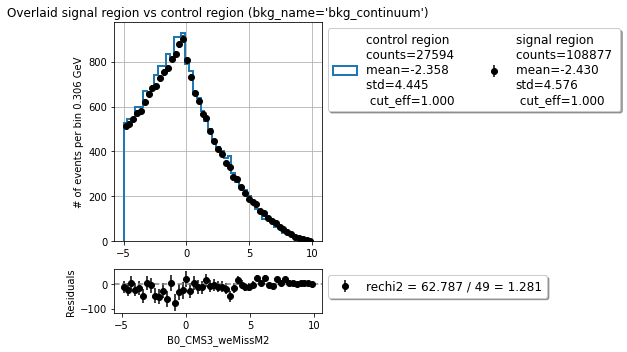

In [17]:
# compare control vs signal regions MC
b1 = np.linspace(-5,10,50)
scale = {'control region': 1,
         'signal region': 50/200}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_continuum',cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

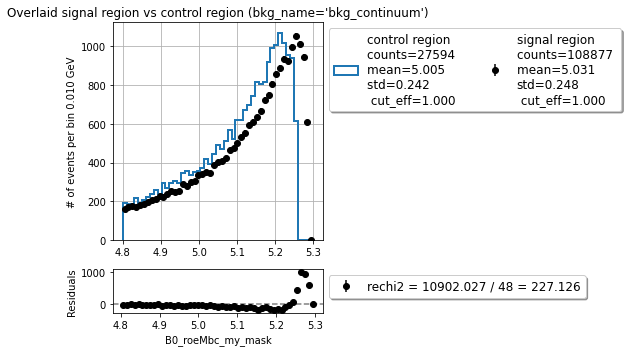

In [13]:
# compare control vs signal regions MC
b1 = np.linspace(4.8,5.3,50)
scale = {'control region': 1,
         'signal region': 50/200}
mpl.plot_mc_sig_control(variable='B0_roeMbc_my_mask',bins=b1,
                        bkg_name='bkg_continuum',cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

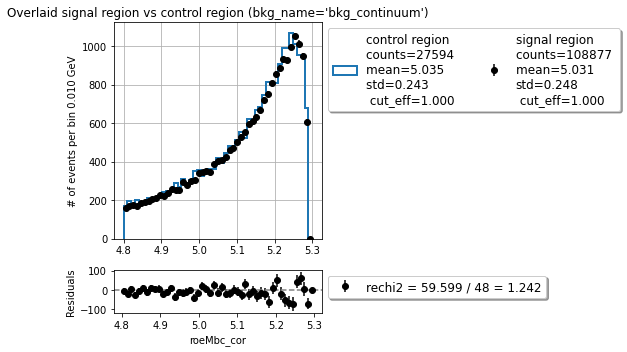

In [14]:
# compare control vs signal regions MC
b1 = np.linspace(4.8,5.3,50)
scale = {'control region': 1,
         'signal region': 50/200}
mpl.plot_mc_sig_control(variable='roeMbc_cor',bins=b1,
                        bkg_name='bkg_continuum',cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

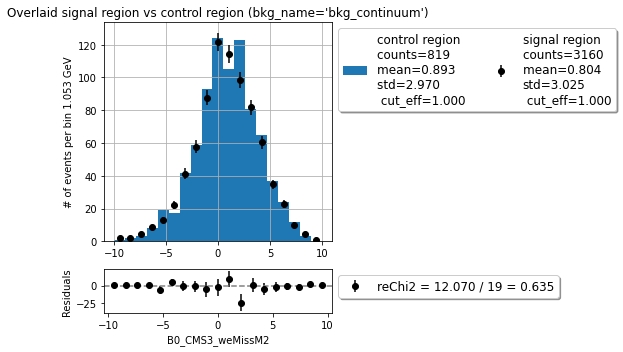

In [8]:
# compare control vs signal regions MC
b1 = np.linspace(-10,10,20)
scale = {'control region': 1,
         'signal region': 50/200}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_continuum',cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

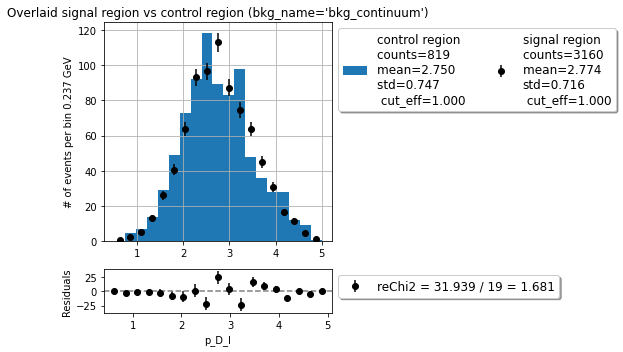

In [8]:
b2 = np.linspace(0.5,5,20)
scale = {'control region': 1,
         'signal region': 50/200}
mpl.plot_mc_sig_control(variable='p_D_l',bins=b2,
                        bkg_name='bkg_continuum',cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

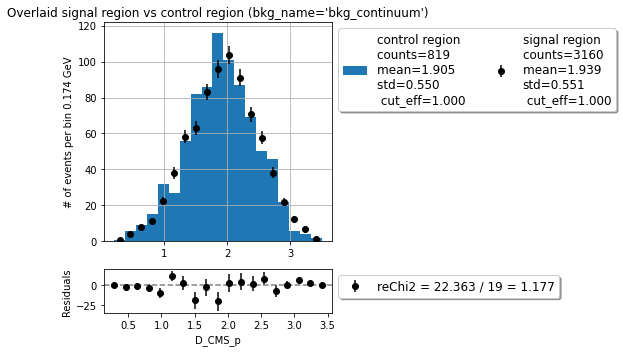

In [13]:
b2 = np.linspace(0.2,3.5,20)
scale = {'control region': 1,
         'signal region': 50/200}
mpl.plot_mc_sig_control(variable='D_CMS_p',bins=b2,
                        bkg_name='bkg_continuum',cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

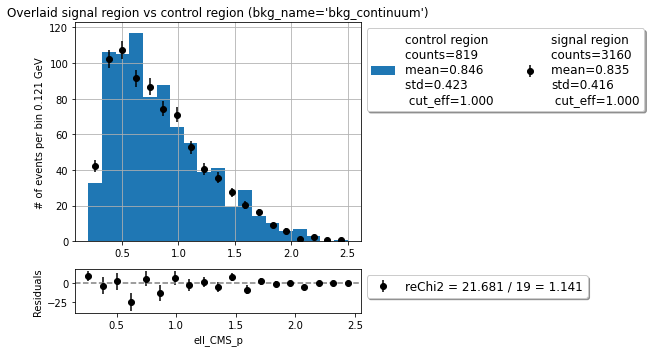

In [12]:
b2 = np.linspace(0.2,2.5,20)
scale = {'control region': 1,
         'signal region': 50/200}
mpl.plot_mc_sig_control(variable='ell_CMS_p',bins=b2,
                        bkg_name='bkg_continuum',cut=None,
                        samples_sig=samples_sig,
                        scale=scale,correction=False,mask=[])

# Check Data vs. MC

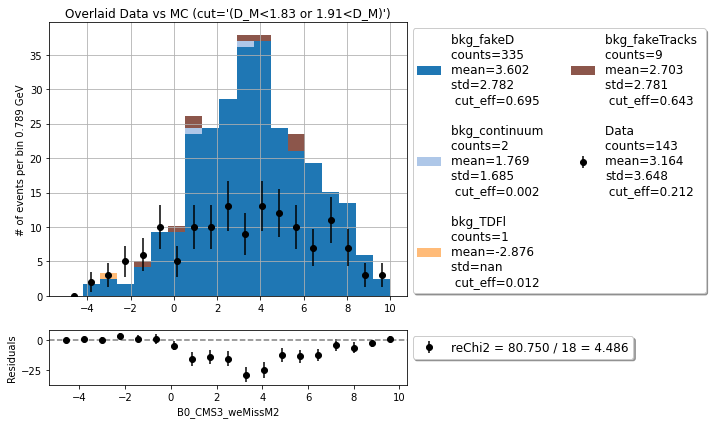

In [9]:
# lgb_tight, D sidebands
b1 = np.linspace(-5,10,20)
a,b=mpl.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,figsize=(10,6),
                          cut='(D_M<1.83 or 1.91<D_M)',
                          scale=[1,42/50],correction=False,mask=[],ratio=False)

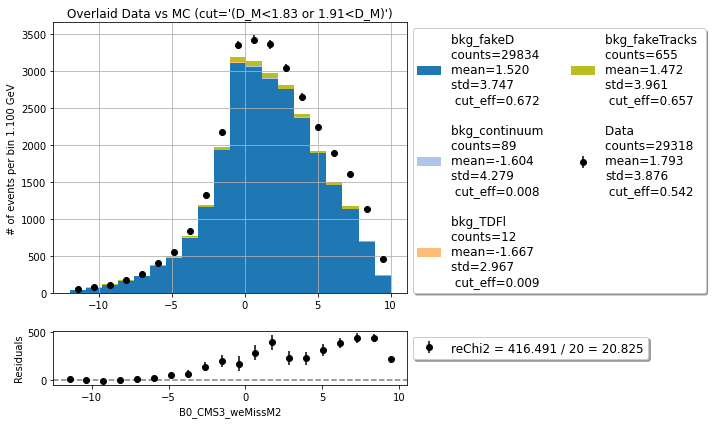

In [28]:
# lgb_trueD, D sidebands
b1 = np.linspace(-12,10,21)
a,b=mpl.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,figsize=(10,6),
                          cut='(D_M<1.83 or 1.91<D_M)',weights={'all_mc':42/50},
                          correction=False,mask=[],ratio=False)

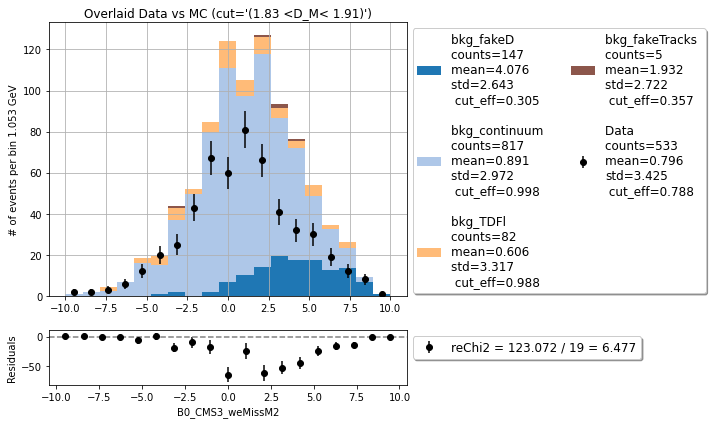

In [10]:
# lgb_tight, D sig
b1 = np.linspace(-10,10,20)
a,b=mpl.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,figsize=(10,6),
                          cut='(1.83 <D_M< 1.91)',
                          scale=[1,42/50],correction=False,mask=[],ratio=False)

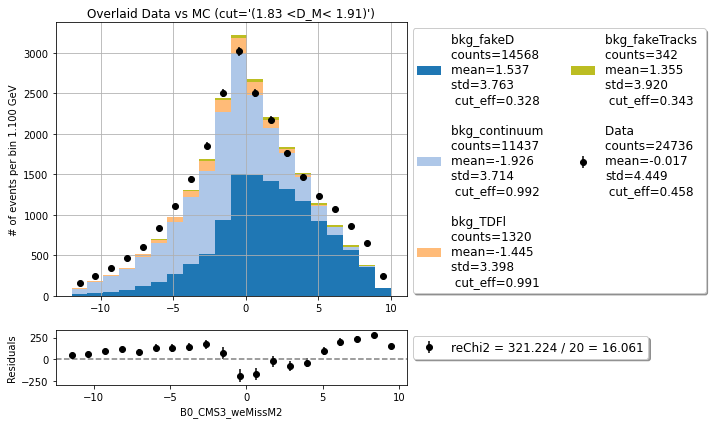

In [29]:
# lgb_trueD, D sig
b1 = np.linspace(-12,10,21)
a,b=mpl.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,figsize=(10,6),
                          cut='(1.83 <D_M< 1.91)',weights={'all_mc':42/50},
                          correction=False,mask=[],ratio=False)

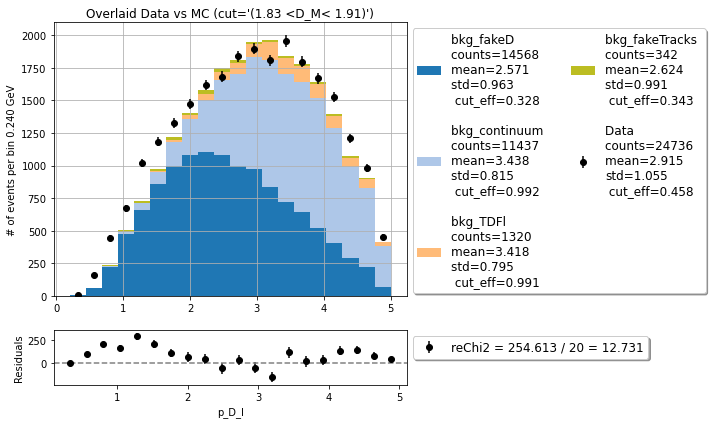

In [43]:
# lgb_trueD, D sig
b1 = np.linspace(0.2,5,21)
a,b=mpl.plot_data_mc_stacked(variable='p_D_l',bins=b1,figsize=(10,6),
                          cut='(1.83 <D_M< 1.91)',weights={'all_mc':42/50},
                          correction=False,mask=[],ratio=False)

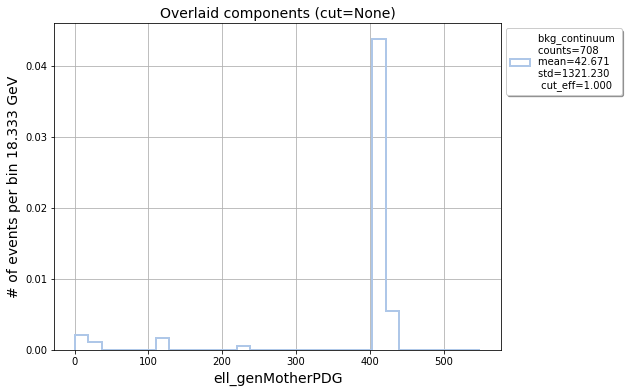

In [15]:
b1 = np.linspace(0,550,31)
mpl.plot_mc_1d_overlaid(variable='ell_genMotherPDG',bins=b1,mask=[],cut=None,
                        show_only=['bkg_continuum'],density=True,legend_nc=1)

In [12]:
samples_4Soff['bkg_fakeTracks'].ell_genMotherPDG.value_counts()

ell_genMotherPDG
 421.0     4
-411.0     2
-15.0      1
-421.0     1
 15.0      1
 22.0      1
 2214.0    1
Name: count, dtype: int64

# Create data driven template for continuum
## 1. Calculate the sidebands to sig region scaling factors
### a. Histogram the D_M distribution

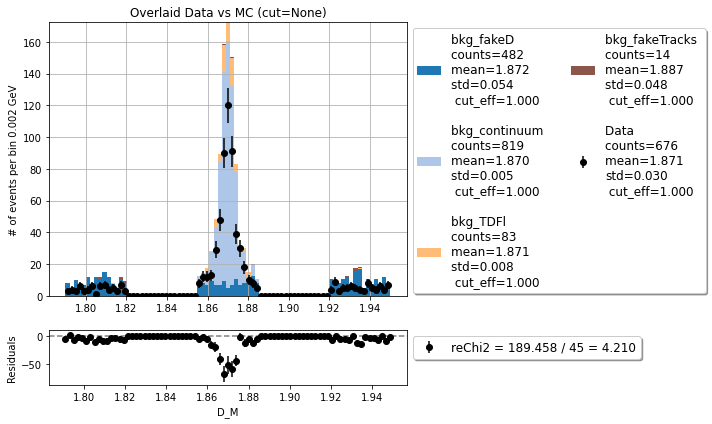

In [42]:
# BDT signal region
b1 = np.linspace(1.79,1.95,81)
weights={'all_mc':42/50}
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(variable='D_M',bins=b1,cut=None,
                                                      weights=weights,correction=False,
                                                      mask=[],figsize=(10,6),ratio=False)

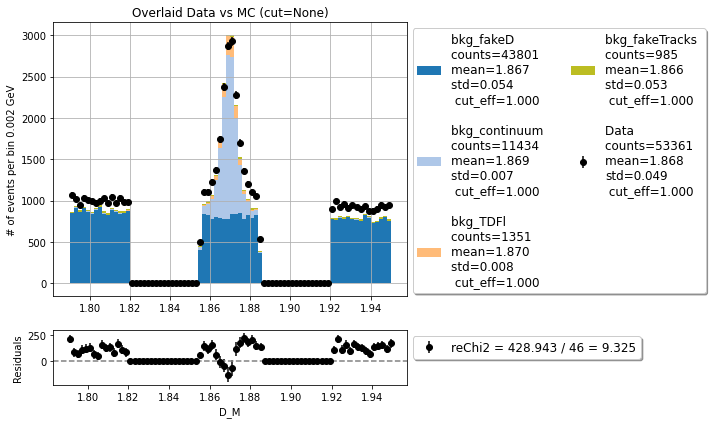

In [8]:
# lgb_trueD
b1 = np.linspace(1.79,1.95,81)
weights={'all_mc':42/50}
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(variable='D_M',bins=b1,cut=None,
                                                      weights=weights,correction=False,
                                                      mask=[],figsize=(10,6),ratio=False)

### b. fit the FakeD with a polynomial

In [9]:
fitter = util.fit_Dmass(x_edges=b1, hist=data_hist_all, poly_only=True)

In [10]:
m_ls, c_ls, result_ls = fitter.fit_gauss_poly_LS(deg=1, loss='linear') #'soft_l1'
m_ls
# fitter.plot_poly(x=bin_edges_sb, y=data_hist_sb, yerr=data_err_sb,result=result)

initial parameters= [ 1.0670e+02  1.8700e+00  5.0000e-02 -6.2170e+02  2.1267e+03]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 31.63 (chi2/ndof = 1.2)    │              Nfcn = 49               │
│ EDM = 2e-13 (Goal: 0.0002)       │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    0.0    │    1.1    │            │            │    0    │         │  yes  │
│ 1 │ x1   │   1.870   │   0.019   │            │            │    0    │         │  yes  │
│ 2 │ x2   │  50.0e-3  │  0.5e-3   │            │            │    0    │         │  yes  │
│ 3 │ x3   │   -630    │    90     │            │            │         │         │       │
│ 4 │ x4   │  2.13e3   │  0.16e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4 │
├────┼───────────────────────────────────────────────────┤
│ x0 │         0         0         0         0         0 │
│ x1 │         0         0         0         0         0 │
│ x2 │         0         0         0         0         0 │
│ x3 │         0         0         0  7.64e+03 -1.43e+04 │
│ x4 │         0         0         0 -1.43e+04  2.69e+04 │
└────┴───────────────────────────────────────────────────┘

In [11]:
m_ml, c_ml, result_ml = fitter.fit_gauss_poly_ML(deg=1)
m_ml
# fitter.plot_poly(x=bin_edges_sb, y=data_hist_sb, yerr=data_err_sb,result=result)

initial parameters= [ 1.0670e+02  1.8700e+00  5.0000e-02  5.3361e+04 -6.2170e+02  2.1267e+03]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 31.67 (chi2/ndof = 1.2)    │              Nfcn = 207              │
│ EDM = 2.87e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    0.0    │    1.1    │            │            │    0    │         │  yes  │
│ 1 │ x1   │   1.870   │   0.019   │            │            │    0    │         │  yes  │
│ 2 │ x2   │  50.0e-3  │  0.5e-3   │            │            │    0    │         │  yes  │
│ 3 │ x3   │  77.1e3   │   0.5e3   │            │            │         │         │       │
│ 4 │ x4   │  -0.08e6  │  0.11e6   │            │            │         │         │       │
│ 5 │ x5   │   0.3e6   │   0.4e6   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────────────────────────────────────────┐
│    │        x0        x1        x2        x3        x4        x5 │
├────┼─────────────────────────────────────────────────────────────┤
│ x0 │         0         0         0         0         0         0 │
│ x1 │         0         0         0         0         0         0 │
│ x2 │         0         0         0         0         0         0 │
│ x3 │         0         0         0  2.13e+05 -2.67e+04 -1.09e+05 │
│ x4 │         0         0         0 -2.67e+04  1.19e+10 -4.04e+10 │
│ x5 │         0         0         0 -1.09e+05 -4.04e+10  1.38e+11 │
└────┴─────────────────────────────────────────────────────────────┘

### c. Calculate the yield ratio

In [ ]:
area_left,error_left = fitter.poly_integral(xrange=[1.79,1.82],result=result_ls)
area_sig, error_sig = fitter.poly_integral(xrange=[1.855,1.885],result=result_ls)
area_right,error_right = fitter.poly_integral(xrange=[1.92,1.95],result=result_ls)

In [12]:
yields_left = fitter.poly_integral(xrange=[1.79,1.82],result=result_ml)
yields_sig = fitter.poly_integral(xrange=[1.855,1.885],result=result_ml)
yields_right = fitter.poly_integral(xrange=[1.92,1.95],result=result_ml)

Yields from 1.79 to 1.82 = 15068.792 ± 125.637
Yields from 1.855 to 1.885 = 14457.361 ± 86.555
Yields from 1.92 to 1.95 = 13845.929 ± 117.189


In [36]:
a = len(samples_4Soff['bkg_fakeD'].query('1.79<D_M<1.82'))
b = len(samples_4Soff['bkg_fakeD'].query('1.92<D_M<1.95'))
print('truth',a,b, a/b)

truth 15746 14088 1.1176888131743328


### d. Plot and compare MC of the weighted sideband and signal region

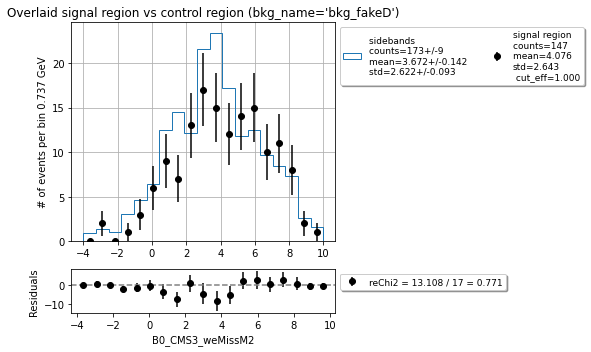

In [25]:
# showing the scaled sidebands vs. sig region from mc
b1 = np.linspace(-4,10,20)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_fakeD',cut=None,merge_sidebands=True,
                        scale=scale,correction=False,mask=[],legend_fs=9)

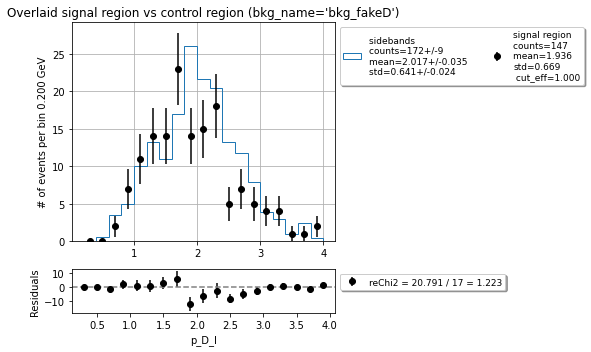

In [26]:
b2 = np.linspace(0.2,4,20)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='p_D_l',bins=b2,merge_sidebands=True,
                        bkg_name='bkg_fakeD',cut=None,
                        scale=scale,correction=False,mask=[],legend_fs=9)

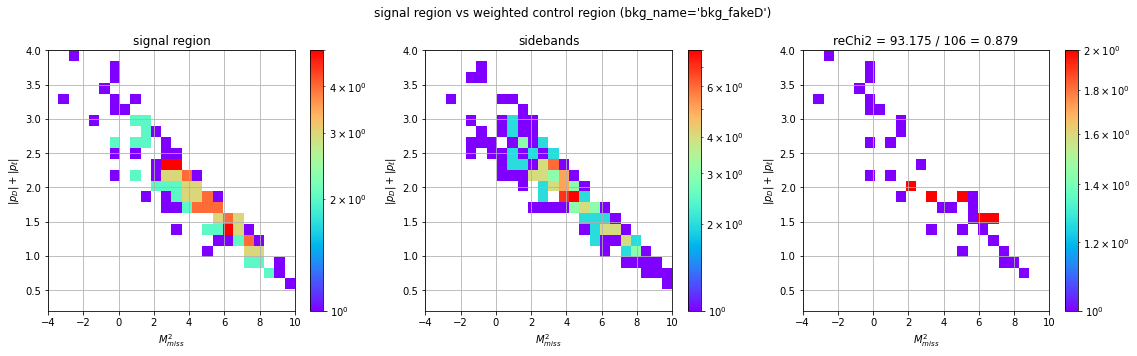

In [50]:
b1 = np.linspace(-4,10,25)
b2 = np.linspace(0.2,4,25)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable=['B0_CMS3_weMissM2','p_D_l'],
                        bins=[b1,b2],
                        bkg_name='bkg_fakeD',cut=None,merge_sidebands=True,
                        scale=scale,correction=True,mask=[],figsize=(16,5))

## 2. Subtract the FakeD in the signal region

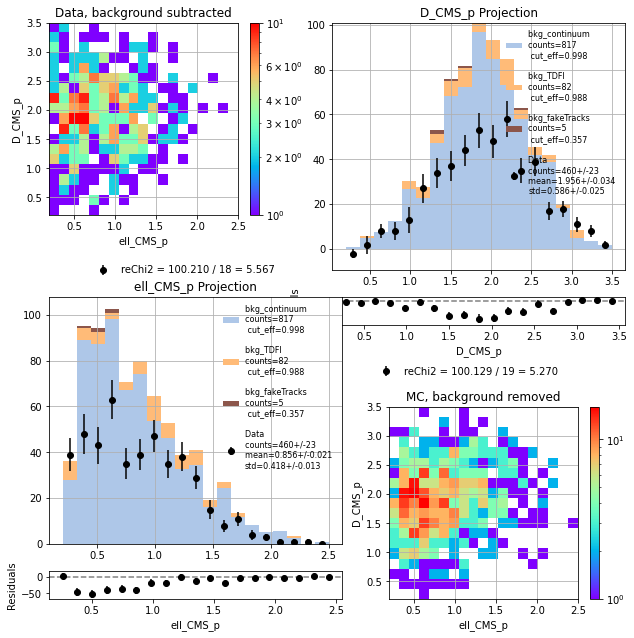

In [39]:
# BDT signal, pl; pd
b_mm2 = np.linspace(0.2,2.5,21)
b_pDl = np.linspace(0.2,3.5,21)
scale = {'data left sideband': yields_sig/yields_left/2,
         'data signal region': 1,
         'data right sideband': yields_sig/yields_right/2,
         'mc signal region': 42/50}
par_dict={'var_list':['ell_CMS_p','D_CMS_p'],
          'bin_list': [b_mm2, b_pDl],
          'cut': None,
          'scale': scale,
          'correction': False,
          'mask': ['bkg_fakeD']}
mpl.plot_data_subtracted_and_mc(**par_dict)

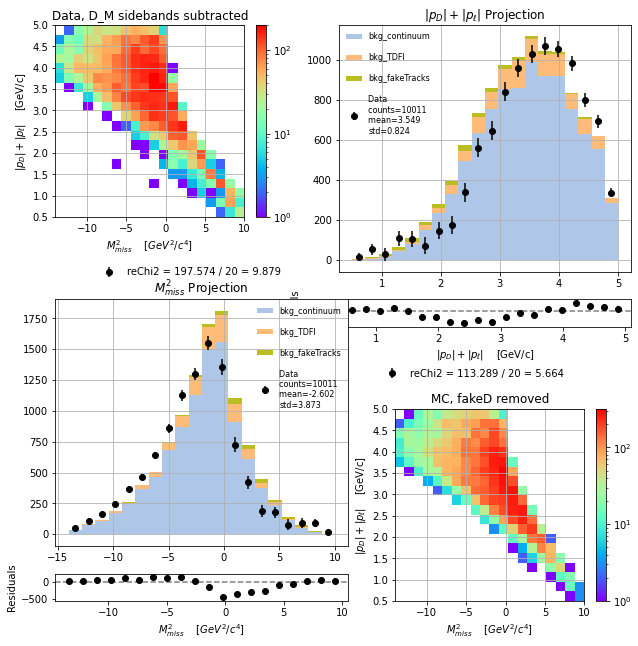

In [13]:
# e channel, lgb_trueD
b_mm2 = np.linspace(-14,10,21)
b_pDl = np.linspace(0.5,5,21)
scale = {'data left sideband': 14457/15068/2,
         'data signal region': 1,
         'data right sideband': 14457/13845/2,
         'all_mc': 42/50}
par_dict={'var_list':['B0_CMS3_weMissM2','p_D_l'],
          'bin_list': [b_mm2, b_pDl],
          'cut': 'ell_p>0', #'B0_roeMbc_my_mask>5.1 and -4<B0_roeDeltae_my_mask<1',
          'weights': scale,
          'correction': False,
          'mask': ['bkg_fakeD']}
indices_threshold, temp_data = mpl.plot_data_subtracted_and_mc(**par_dict)

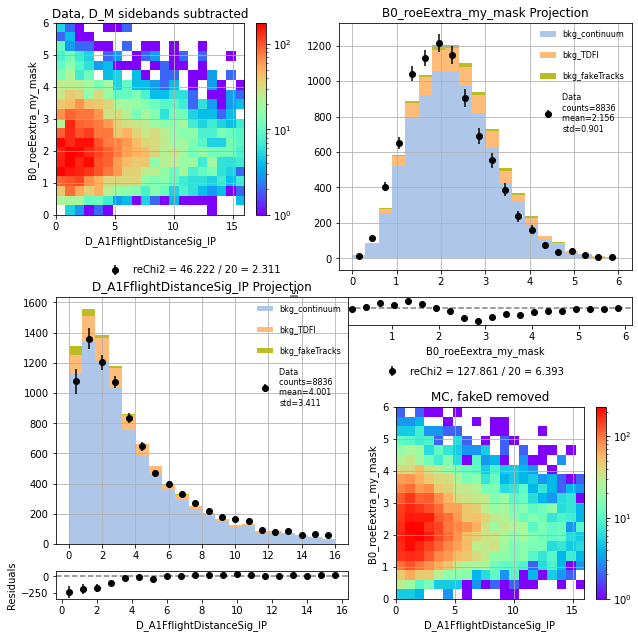

In [14]:
# e channel, lgb_trueD
b_mm2 = np.linspace(0,16,21)
b_pDl = np.linspace(0,6,21)

par_dict={'var_list':['D_A1FflightDistanceSig_IP','B0_roeEextra_my_mask'],
          'bin_list': [b_mm2, b_pDl],
          'cut': 'ell_p>0', #'B0_roeMbc_my_mask>5.1 and -4<B0_roeDeltae_my_mask<1',
          'weights': scale,
          'correction': False,
          'mask': ['bkg_fakeD']}
indices_threshold, temp_data = mpl.plot_data_subtracted_and_mc(**par_dict)

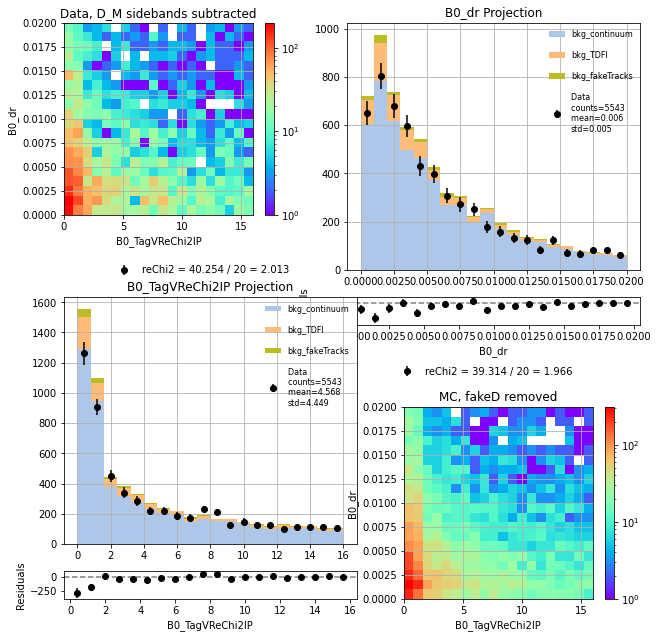

In [16]:
# e channel, lgb_trueD
b_mm2 = np.linspace(0,16,21)
b_pDl = np.linspace(0,0.02,21)

par_dict={'var_list':['B0_TagVReChi2IP','B0_dr'],
          'bin_list': [b_mm2, b_pDl],
          'cut': 'ell_p>0', #'B0_roeMbc_my_mask>5.1 and -4<B0_roeDeltae_my_mask<1',
          'weights': scale,
          'correction': False,
          'mask': ['bkg_fakeD']}
indices_threshold, temp_data = mpl.plot_data_subtracted_and_mc(**par_dict)

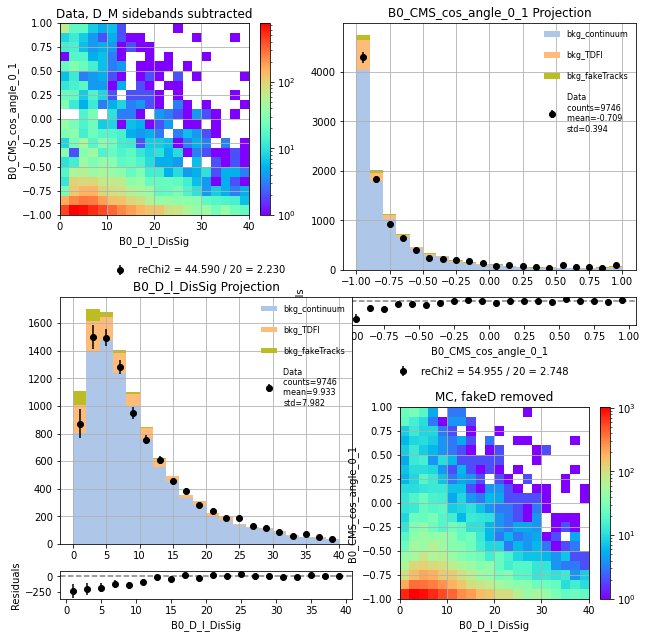

In [17]:
# e channel, lgb_trueD
b_mm2 = np.linspace(0,40,21)
b_pDl = np.linspace(-1,1,21)

par_dict={'var_list':['B0_D_l_DisSig','B0_CMS_cos_angle_0_1'],
          'bin_list': [b_mm2, b_pDl],
          'cut': 'ell_p>0', #'B0_roeMbc_my_mask>5.1 and -4<B0_roeDeltae_my_mask<1',
          'weights': scale,
          'correction': False,
          'mask': ['bkg_fakeD']}
indices_threshold, temp_data = mpl.plot_data_subtracted_and_mc(**par_dict)

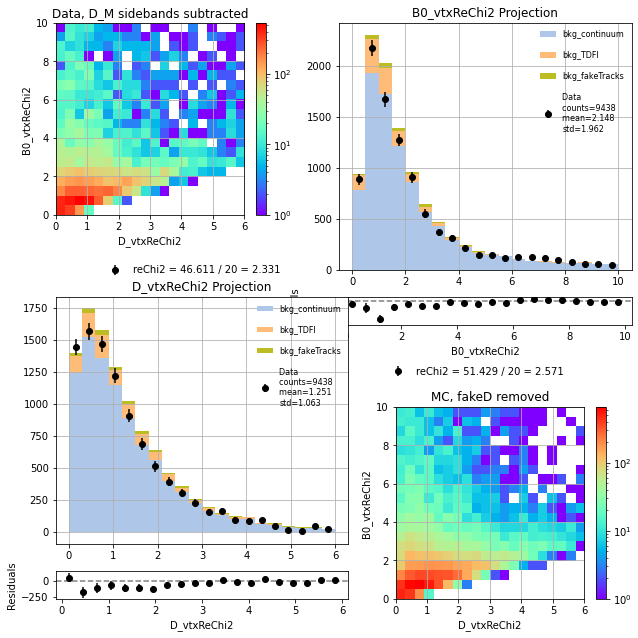

In [18]:
# e channel, lgb_trueD
b_mm2 = np.linspace(0,6,21)
b_pDl = np.linspace(0,10,21)

par_dict={'var_list':['D_vtxReChi2','B0_vtxReChi2'],
          'bin_list': [b_mm2, b_pDl],
          'cut': 'ell_p>0', #'B0_roeMbc_my_mask>5.1 and -4<B0_roeDeltae_my_mask<1',
          'weights': scale,
          'correction': False,
          'mask': ['bkg_fakeD']}
indices_threshold, temp_data = mpl.plot_data_subtracted_and_mc(**par_dict)

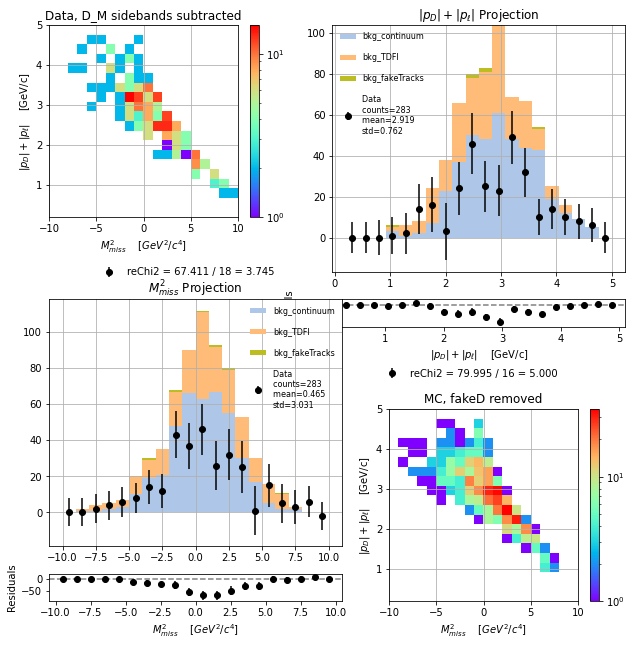

In [32]:
# mu channel
b_mm2 = np.linspace(-10,10,21)
b_pDl = np.linspace(0.2,5,21)
scale = {'data left sideband': 75/64/2 * 50/24,
         'data right sideband': 75/86/2 * 50/24,
         'data signal region': 50/24}

par_dict={'var_list':['B0_CMS3_weMissM2','p_D_l'],
          'bin_list': [b_mm2, b_pDl],
          'cut': 'ell_p>0', #'B0_roeMbc_my_mask>5.1 and -4<B0_roeDeltae_my_mask<1',
          'weights': scale,
          'correction': False,
          'mask': ['bkg_fakeD']}
indices_threshold, temp_data = mpl.plot_data_subtracted_and_mc(**par_dict)